<a href="https://colab.research.google.com/github/kevenbazile/TradingBot-Colabs/blob/main/Tradingbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install yfinance

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [18]:
# The code here will allow you to switch your graphics to dark mode for those who choose to code in dark mode
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")

Data Preparation


In [19]:
def preprocessing_yf(symbol):

  #Import the data
  df = yf.download(symbol).dropna()

  #Rename
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "time"

  # Remove adj close
  del df["adj close"]

  return df

df = preprocessing_yf("EURUSD=X")
df

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,0
...,...,...,...,...,...
2024-03-04,1.084269,1.086649,1.083858,1.084269,0
2024-03-05,1.085517,1.087536,1.084269,1.085517,0
2024-03-06,1.085600,1.091405,1.084293,1.085600,0


Create Trading Signal

<Axes: xlabel='time'>

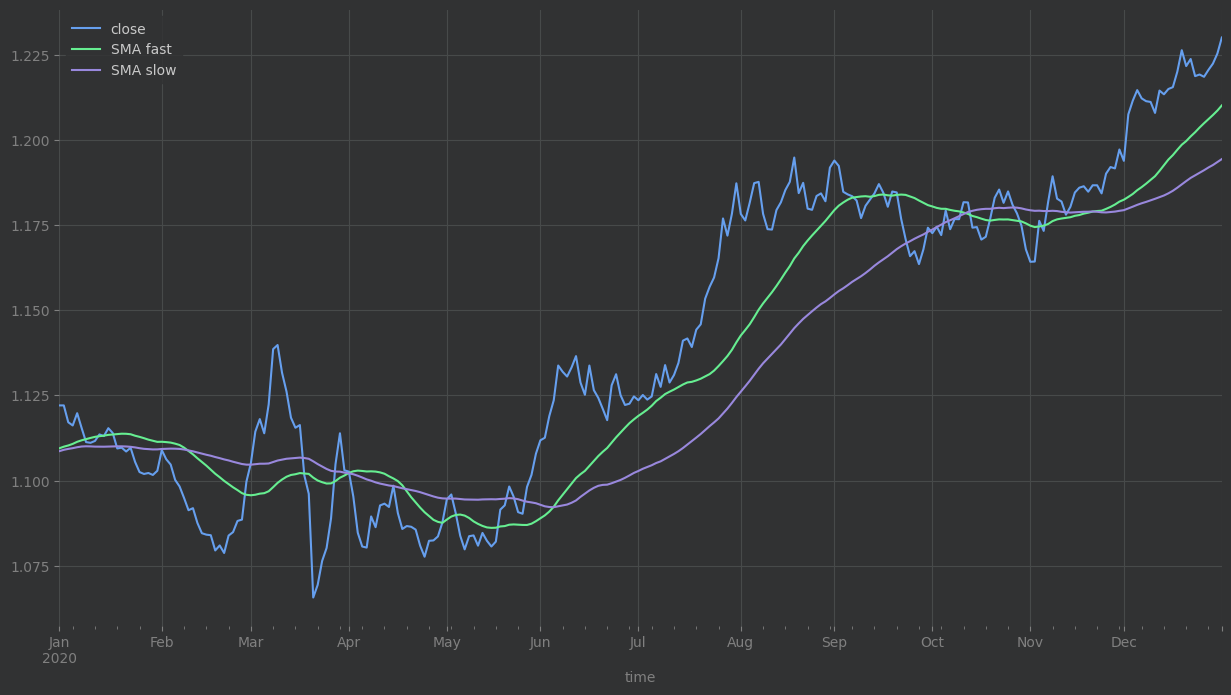

In [20]:
# Create Simple moving average 30 days
df["SMA fast"] = df["close"].rolling(30).mean()

# Create Simple moving average 60 days
df["SMA slow"] = df["close"].rolling(60).mean()

# Plot the results
df[["close", "SMA fast", "SMA slow"]].loc["2020"].plot(figsize=(15,8))

In [21]:
# Create an empty columns to put the signals
df["signal"]=np.nan

# Create the condition
condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))

df.loc[condition_buy, "signal"] = 1
df.loc[condition_sell, "signal"] = -1

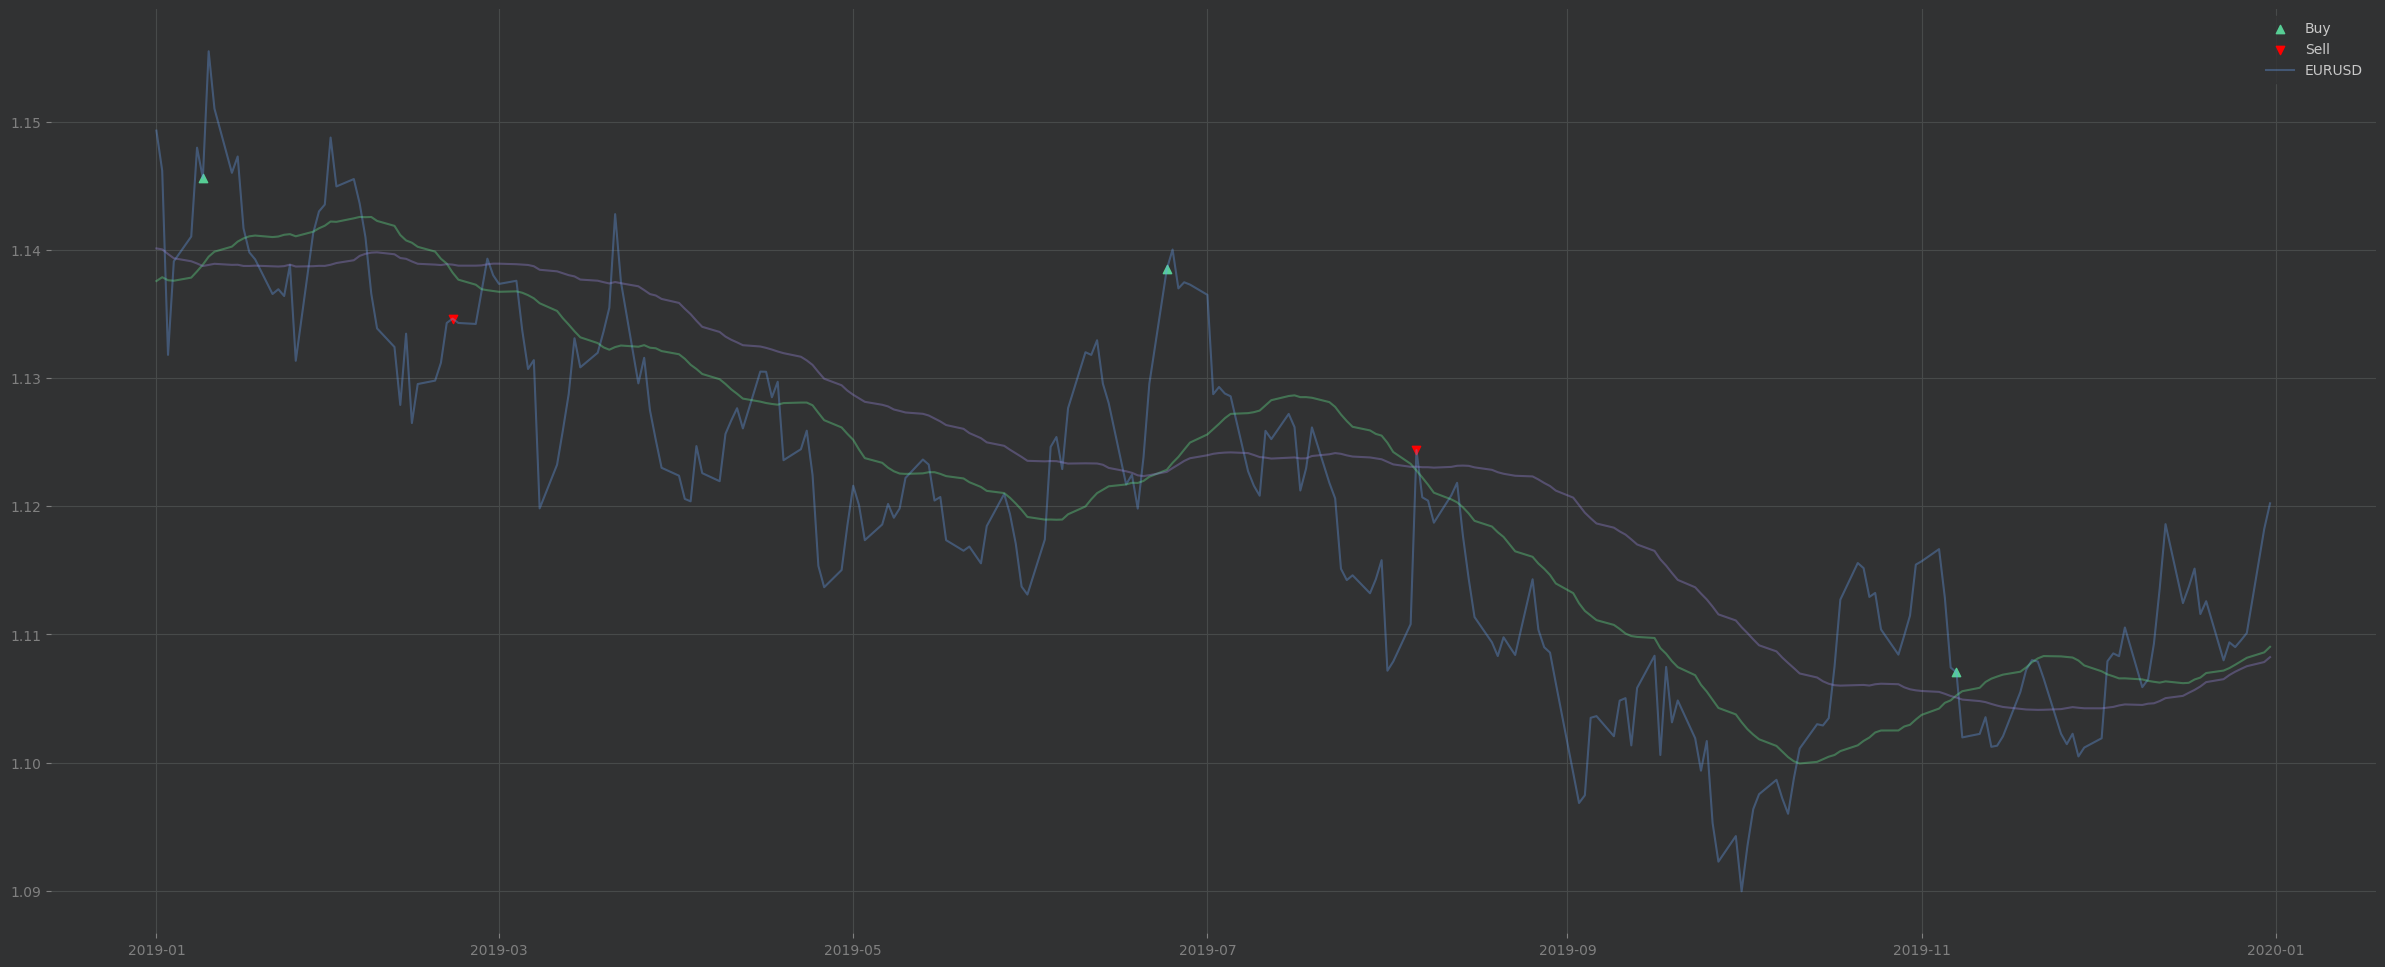

In [22]:
# We plot all the signla to be sure that they be correct

year="2019"

# Select all signal in a index list to plot only this points
idx_open = df.loc[df["signal"] == 1].loc[year].index
idx_close = df.loc[df["signal"] == -1].loc[year].index



# Adapt the size of the graph
plt.figure(figsize=(30,12))

# Plot the points of the open long signal in green and sell in red
plt.scatter(idx_open, df.loc[idx_open]["close"].loc[year], color= "#57CE95", marker="^")
plt.scatter(idx_close, df.loc[idx_close]["close"].loc[year], color= "red", marker="v")


# Plot the resistance to be sure that the conditions are completed
plt.plot(df["close"].loc[year].index, df["close"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA fast"].loc[year], alpha=0.35)

plt.plot(df["close"].loc[year].index, df["SMA slow"].loc[year], alpha=0.35)

plt.legend(["Buy", "Sell", "EURUSD"])

# Show the graph
plt.show()

COMPUTE PROFIT LOSS

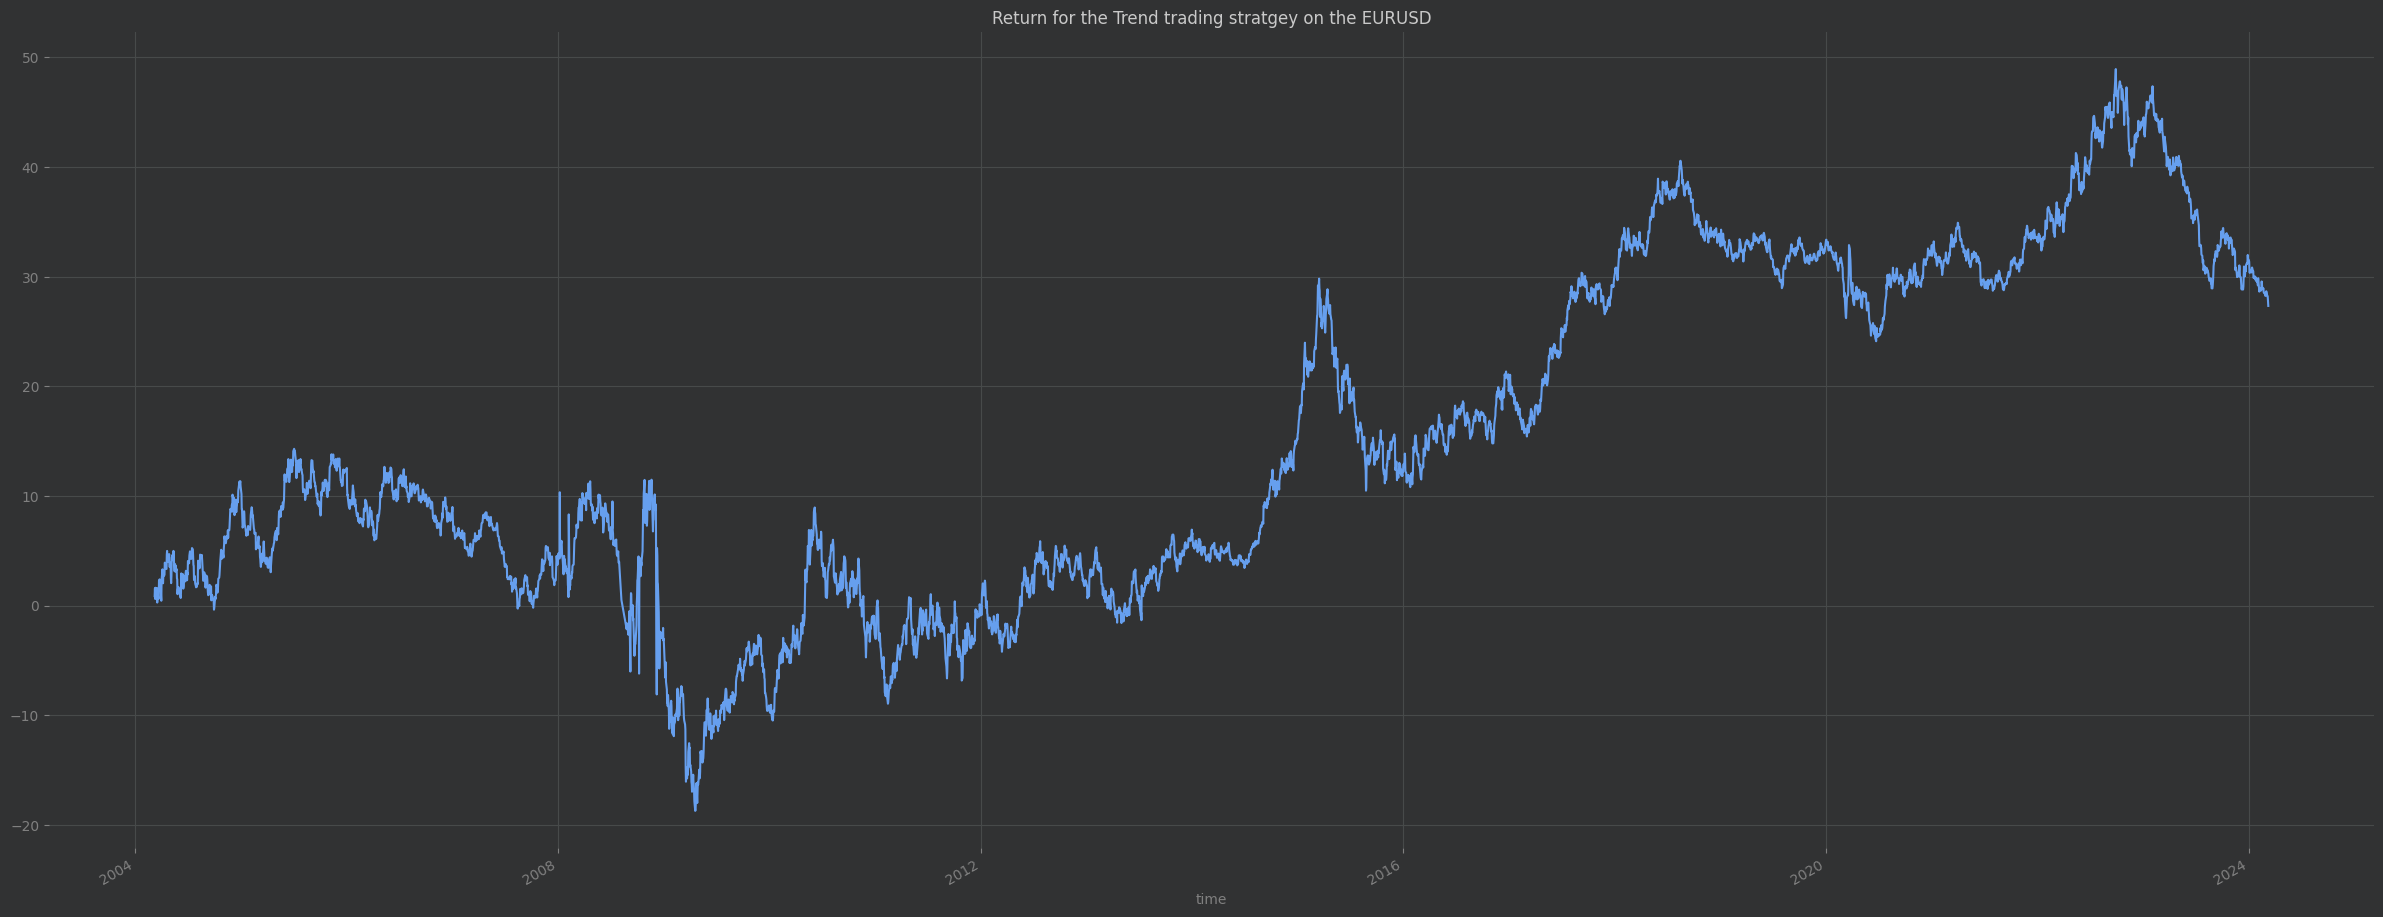

In [23]:
# We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
df["position"] = df["signal"].fillna(method="ffill")

# We define a fix cost we need to pay each time we interact with the market
cost_ind = 0.0001

# We create a vector of cost
df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0) #(-0.0001, 0, 0, 0, 0, 0 , 0, -0.0001, 0, 0) (-0.0001,-0.0001,-0.0001,-0.0001,-0.0001,)

# Compute the percentage of variation of the asset
df["pct"] = df["close"].pct_change(1)

# Compute the return of the strategy
df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100


df["return"].cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey on the EURUSD")
plt.show()

Automate Process

In [24]:
def SMA_strategy(input, fast_sma=30, slow_sma=60, cost_ind=0.0001):

  df = preprocessing_yf(input)


  # Create Resistance using a rolling max
  df["SMA fast"] = df["close"].rolling(fast_sma).mean()

  # Create Support using a rolling min
  df["SMA slow"] = df["close"].rolling(slow_sma).mean()

  # Create an empty columns to put the signals
  df["signal"]=np.nan

  # Create the condition
  condition_buy = (df["SMA fast"] > df["SMA slow"]) & (df["SMA fast"].shift(1) < df["SMA slow"].shift(1))
  condition_sell = (df["SMA fast"] < df["SMA slow"]) & (df["SMA fast"].shift(1) > df["SMA slow"].shift(1))

  df.loc[condition_buy, "signal"] = 1
  df.loc[condition_sell, "signal"] = -1

  # We say signal when we open or close a trade and poistion to talk about the whole time we are into a trade
  df["position"] = df["signal"].fillna(method="ffill")

  # We create a vector of cost
  df["cost"] = (np.abs(df["signal"]) * cost_ind).fillna(value=0)

  # Compute the percentage of variation of the asset
  df["pct"] = df["close"].pct_change(1)

  # Compute the return of the strategy
  df["return"] = (df["pct"] * df["position"].shift(1) - df["cost"])*100


  return df["return"]

[*********************100%%**********************]  1 of 1 completed


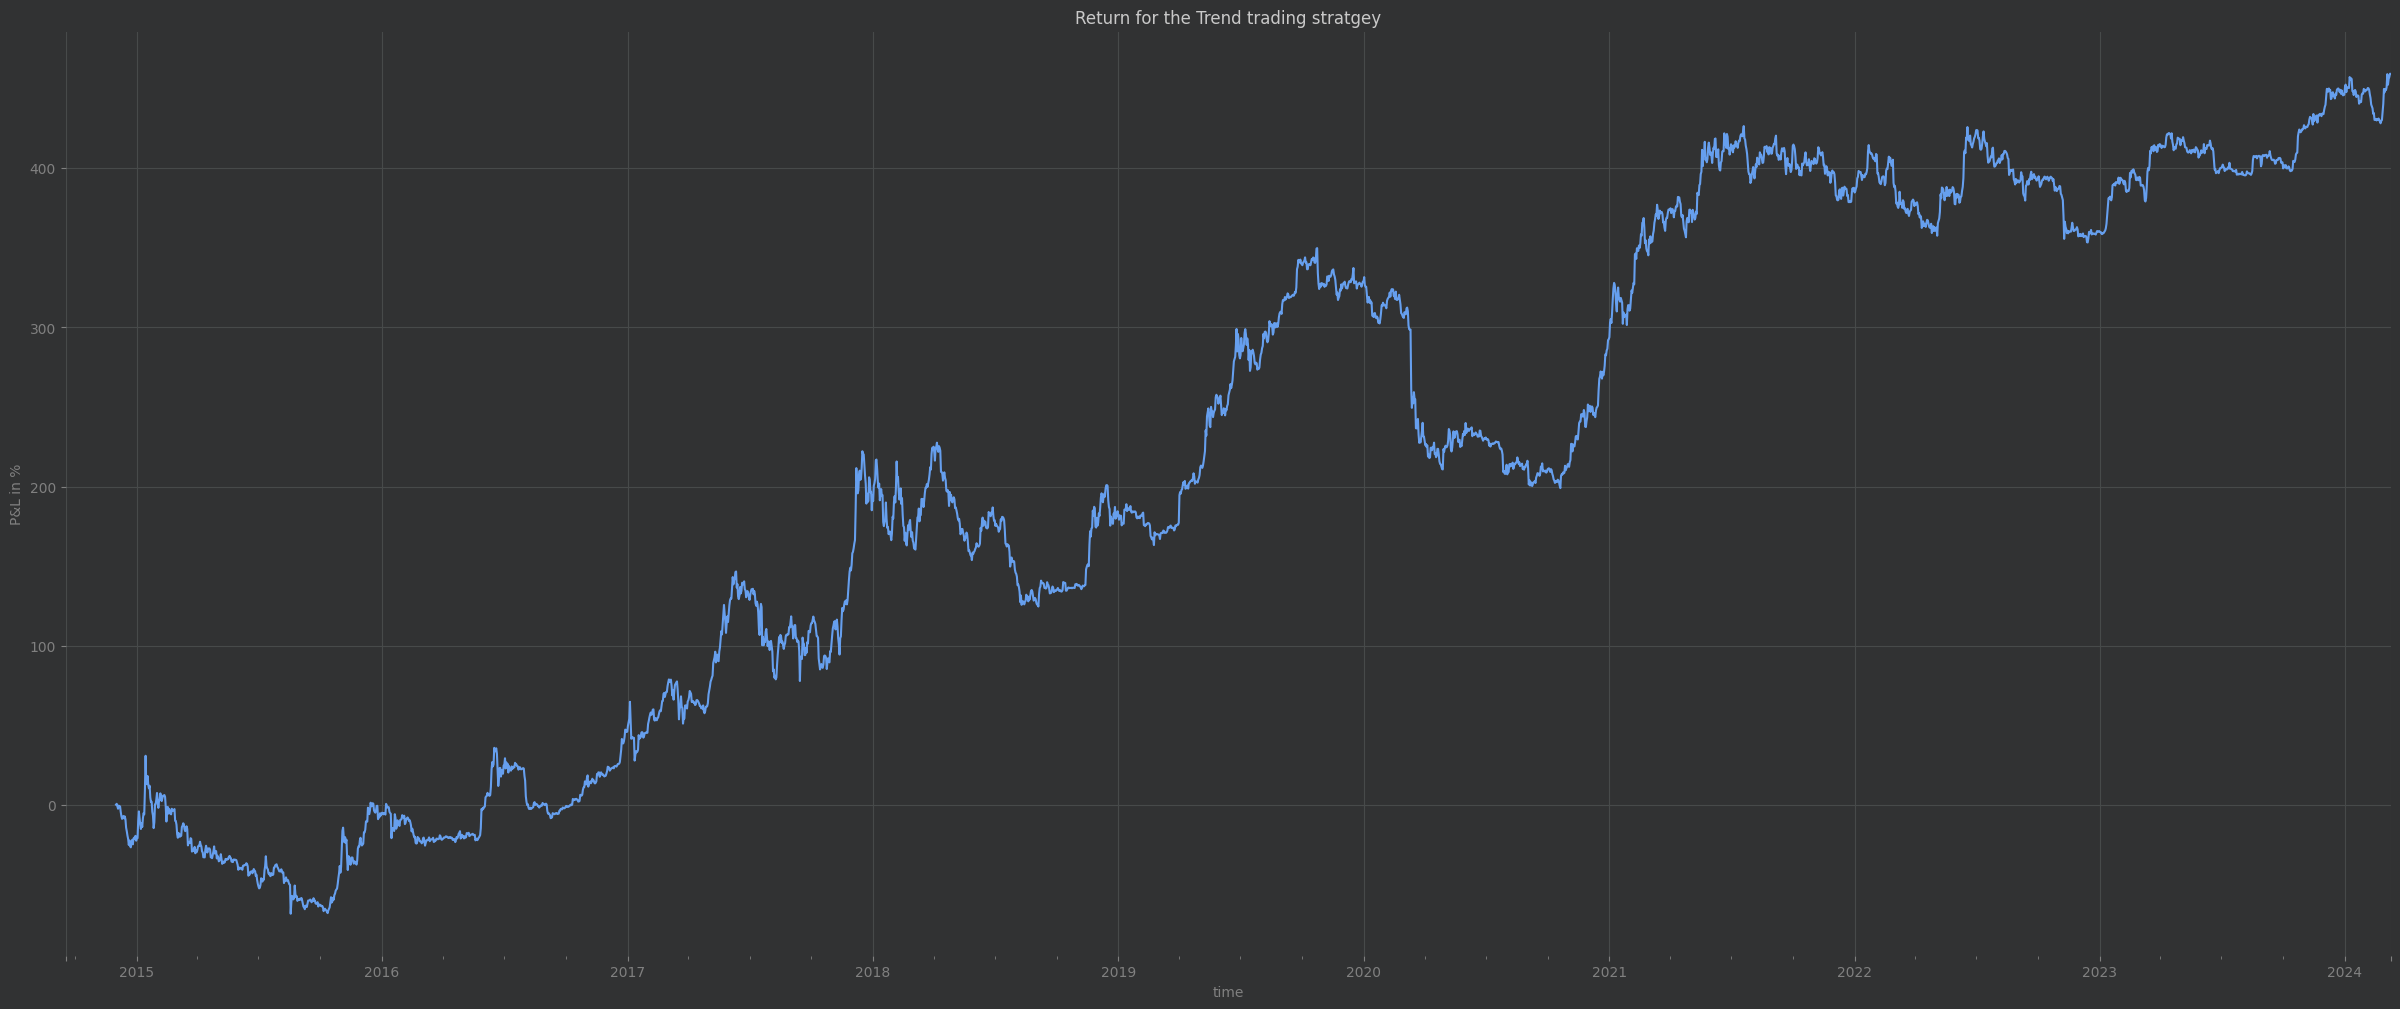

In [25]:
SMA_strategy("BTC-USD", 30,60,0.001).cumsum().plot(figsize=(30,12), title="Return for the Trend trading stratgey", ylabel="P&L in %")
plt.show()